In [1]:
import sys
#sys.path.append(r'D:\Anaconda\Lib\site-packages')
import pandas
import struct
#pip
import seaborn as sns
from scipy.optimize import curve_fit
import scipy.stats as stats 
import numpy as np
import pandas as pd
from scipy.fftpack import fft,ifft
from scipy.optimize import curve_fit
from scipy.optimize import root
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def mbb(MA,EQ,T2vbb,G0v,M0v,FWHM,Exposure,Abd=1):
    me=0.511
    NA=6.02e23
    k=8.5
    ln2=np.log(2)
    F=(k*EQ*FWHM**6)/me
    A=MA*k*EQ*FWHM**6
    B=ln2*NA*Exposure*Abd*0.76*me*T2vbb
    C=1/(G0v*M0v**2)
    mbb=me*(A/B)**(1/4)*C**(1/2)
    T0vbb=1/(G0v*M0v**2*(mbb/me)**2)
    SB=T2vbb/(F*T0vbb)
    Bkg=ln2*NA*k*EQ*FWHM**6*Exposure/(T2vbb*MA*me)
    return mbb,Bkg,SB,T0vbb

def sb(T2vbb,mbb,EQ,FWHM,G0v,M0v,MA):
    me=0.511
    NA=6.02e23
    k=8.5
    ln2=np.log(2)
    epsilon=0.762
    F=(k*EQ*FWHM**6)/me
    T0vbb=1/(G0v*M0v**2*(mbb/me)**2)
    sb=(T2vbb/(F*T0vbb))
    
    Es=107.6
  
    Exp=Es*MA*T0vbb/(ln2*NA*epsilon)
    print(F,sb,Es,Exp,T0vbb)
    return sb,Exp

    
def double_betaF(EQ,range_l=0,range_h=1.2,pointN_=12000):
    E=np.linspace(range_l*EQ,range_h*EQ,pointN)
    FE1=0#(E**4+10*E**3+40*E**2+60*E+30)*E*(EQ-E)**5
    FE2=E**3*(E**4+14*E**3+84*E**2+140*E+70)*(EQ-E)**7
    FE=FE1+FE2
    for i in range(pointN):
        if FE[i]<0:
            FE[i]=0
    FE=FE/np.sum(FE)
    return FE

def nless_double_betaF(EQ,FWHM,range_l=0,range_h=1.2,pointN_=12000):
    E=np.linspace(range_l*EQ,range_h*EQ,pointN)
    sigma=FWHM/2.355
    FE=np.exp(-(E-EQ)**2/(2*sigma**2))
    FE=FE/np.sum(FE)
    return FE
    
def convFWHM(FE,FWHM,range_l=0,range_h=1.2,):
    length=FE.size
    FEconv=np.zeros((length,))
    ####conv gauss fun 
    sigma=FWHM/2.355
    Width=0.5
    N=int(2*Width/(range_h-range_l)*length)
    Conv=np.linspace(-Width,Width,N)
    Gauss=np.exp(-(Conv)**2/(2*sigma**2))
    Gauss=Gauss/np.sum(Gauss)
    for i in range(length):
        for tau in range(max(i-int(N/2),0),min(i+int(N/2)-1,length)):
            FEconv[i]+=Gauss[i-tau+(int(N/2)-1)]*FE[tau] 
    return FEconv    

def convert(range_l,range_h,pointN,FWHM):
    start=int(pointN*(1-0.5*FWHM-range_l)/(range_h-range_l))
    end=int(pointN*(1+0.5*FWHM-range_l)/(range_h-range_l))
    return start, end


def nu_eff(m0):
    # unit eV
    s12=np.array([2.75,3.5])*0.1
    s23=np.array([4.27,6.09])*0.1
    s13=np.array([2.046,2.440])*0.01
    c12=1-s12
    c23=1-s23
    c13=1-s13
    m21=np.array([6.79,8.01])*1e-5
    m32=np.array([2.358,2.544])*1e-3
    #delta=np.array([141,370])*math.pi/180
    delta=0
    n1=0
    n2=0
    u1=m0*c12*c13
    u2=np.sqrt(m21+m0**2)*s12*c13*np.exp(2j*(n2-n1))
    u3=np.sqrt(m32+m21+m0**2)*s13*np.exp(-2j*(delta+n1))
    nueff=abs(u1+u2+u3)
    return nueff
    


In [8]:
class Iso:
    def __init__(self,Name="null",EQ=1,FWHM=1,T2vbb=1,MA=1,MoluM=1,G0v=[1,2],M0v=[1,2],Abd=1,Color='r',BRange=[-3,4],StepN=3000,P=0.00135):
        self.Name=Name
        self.EQ=EQ
        self.FWHM=FWHM
        self.T2vbb=T2vbb
        self.MA=MA
        self.G0v=G0v
        self.M0v=M0v
        self.Abd=Abd
        self.MoluM=MoluM
        self.Color=Color
        self.BRange=BRange
        self.StepN=StepN
        self.P=P
        
        self.Bi=np.zeros((StepN,3),dtype=float)          # unit: c/(keV*t*y)
        self.Exp=np.zeros((StepN,3),dtype=float)         # unit: t*y
        self.Mbb=np.zeros((StepN,3),dtype=float)         # unit: meV
        self.T0vbb=np.zeros((StepN,3),dtype=float)       #T unit: y^
        self.S=np.zeros((StepN,3),dtype=float)           # s-b,in 3 conditions,signal counts 
        self.B=np.zeros((StepN,),dtype=float)            # s-b, background counts unit: c/RoI
        self.x=np.zeros((StepN,),dtype=float)
        self.y=np.zeros((StepN,),dtype=float)           #
        
        self.me=0.511
        self.ln2=np.log(2)
        self.NA=6.02e23
        self.epsilon=0.76
        self.meV=1e-9                                   #1e-9 MeV
        
        self.Bi2v=self.ln2*self.NA*self.F2v(FWHM,EQ)/(MoluM*T2vbb*(FWHM*EQ*1000))    
        print(self.Name,self.Bi2v,self.F2v(FWHM,EQ))
                                                        #Bi2v unit: c/(keV*t*y)
        
        self.StatMode=0                                 # 0 for Poisson, 1 for N counts, 2 for CLs
        self.Calc_SB(P)
        
    ####################
    #calculate s,b
    ####################
    def Calc_SB(self,P):
        BRange=self.BRange
        self.B=np.logspace(BRange[0],BRange[1],self.StepN,10)                    
        for i in range(self.StepN):
            B_counts=self.B[i]
            self.S[i,0]=self.S_Poisson(B_counts)
            self.S[i,1]=self.S_Ncounts(B_counts,P)
            #self.S[i,2]=self.S_CLs(B_counts,P)
            
            ##################
            if(i%1000==0):
                print(i,self.S[i,1])
            
    def S_Poisson(self,B_counts):
        if(B_counts<1):
            return 1
        else:
            return math.sqrt(B_counts)
        
    def S_Ncounts(self,B_counts,P):
        Nobs=stats.poisson.ppf(1-P, B_counts)
        ans=root(self.Poisson,x0=np.max([B_counts,0.6]),args=(int(np.max([Nobs,0]))))  
        return ans.x-B_counts
    
    def S_CLs(self,B_counts,P):
        grid=1e2
        S_init=self.S_Ncounts(B_counts,P)
        for i in range(int(grid)):
            S=S_init*(grid-i)/grid
            CLs=self.CLsM(S,B_counts)
            if(CLs>P):
                return S
        return 0
    
    def CLsM(self,S,B_counts):                           #work to be done 
        if(S+B_counts<=0 or B_counts<=0):
            print("CLsM : S+B_counts<=0 or B_counts<=0 !!!")
            return
        ln=np.log((S+B_counts)/B_counts)
        
        n_sample=10000
        Data_Nb=stats.poisson.rvs(mu=B_counts,size=n_sample)
        Data_Nsb=stats.poisson.rvs(mu=B_counts+S,size=n_sample) 
        Q_Nb=-2*(Data_Nb*ln-S)
        Q_Nsb=-2*(Data_Nsb*ln-S)
        H_Nb,Edge=np.histogram(Q_Nb,bins=100,range=(-50,50),density=True)
        H_Nsb,Edge=np.histogram(Q_Nsb,bins=100,range=(-50,50),density=True)
        Nobs_50=stats.poisson.ppf(mu=S+B_counts,q=0.5)  #observe s more than Nobs (poisson dist) with probability no less than 1-P
        Qobs_50=-2*(Nobs_50*ln-S)
        Nb_sum_mask=Edge[0:len(Edge)-1]<Qobs_50
        Nsb_sum_mask=Edge[0:len(Edge)-1]>Qobs_50
        Q_Nb_sum=H_Nb[Nb_sum_mask].sum()
        Q_Nsb_sum=H_Nsb[Nsb_sum_mask].sum()
        CLs=Q_Nsb_sum/(1-Q_Nb_sum)
        return CLs
        
    def Poisson(self,v,N):  
        return stats.poisson.cdf(N,mu=v)-0.5
    
    ####################
    #calculate Mbb,Exp,Bi
    ####################
    def Bi_Exp(self,mbb=14e-9):
        G0v=self.G0v
        M0v=self.M0v
        MoluM =self.MoluM
        EQ=self.EQ
        FWHM=self.FWHM
        Abd=self.Abd
        me =self.me
        ln2=self.ln2
        NA =self.NA
        epsilon=self.epsilon
        
        
        T0vbb_divide_NA=1/(NA*G0v*M0v**2*(mbb/me)**2)
        
        #
        n=self.StatMode
        for i in range(self.StepN):
            self.Exp[i,n]=self.S[i,n]*MoluM*T0vbb_divide_NA/(ln2 * epsilon * Abd )
            self.Bi[i,n]=self.B[i]/(self.Exp[i,n]*EQ*FWHM*1000)             # convert Mev to keV
    
    def Bi_Mbb(self,exp=1000):
        G0v=self.G0v
        M0v=self.M0v
        MoluM =self.MoluM
        EQ=self.EQ
        FWHM=self.FWHM
        Abd=self.Abd
        me =self.me
        meV=self.meV
        ln2=self.ln2
        NA =self.NA
        epsilon=self.epsilon
        
        n=self.StatMode
        for i in range(self.StepN):
            T0vbb=ln2*NA*exp*epsilon*Abd/(MoluM*self.S[i,n])
            self.Mbb[i,n]=math.log(me/(M0v*math.sqrt(T0vbb*G0v))/meV,10)
            self.Bi[i,n]=self.B[i]/(exp*EQ*FWHM*1000)
            
    def Exp_Mbb(self,bi=0.1):
        bi=bi+self.Bi2v
        print("bi: ",bi)
        G0v=self.G0v
        M0v=self.M0v
        EQ=self.EQ
        FWHM=self.FWHM
        MoluM =self.MoluM
        Abd=self.Abd
        me =self.me
        meV=self.meV
        ln2=self.ln2
        NA =self.NA
        epsilon=self.epsilon
        
        n=self.StatMode
        #self.Exp=np.logspace(1,4,StepN,10)
        
        for i in range(self.StepN):
            exp=self.B[i]/(bi*EQ*FWHM*1000)
            
            T0vbb=ln2*NA*exp*epsilon*Abd/(MoluM*self.S[i,n])
            if(self.S[i,n]<=0):
                print(self.S[i,n],i,self.B[i])
                return
            self.T0vbb[i,n]=T0vbb
            if(me/(M0v*math.sqrt(T0vbb*G0v))<=0):
                print(me/(M0v*math.sqrt(T0vbb*G0v)))
            self.Mbb[i,n]=math.log(me/(M0v*math.sqrt(T0vbb*G0v))/meV,10)   #unit :meV
            self.Exp[i,n]=exp
            
            
    ####################
    #Set Mode, and other
    ####################    
    def SetMode(self,n):
        self.StatMode=int(n)
    
    def F2v(self,FWHM,EQ):
        k=0
        if(FWHM<3):
            k=8.5
        elif(FWHM<7.5):
            k=7
        else:
            k=5
        f=k*(FWHM**6)*EQ/self.me
        return f
            
        

In [9]:
XeFWHM={" (TPC)":2.7e-2," (Scin Best)":4.5e-2," (Scin JUNO)":7.07e-2}
TeFWHM={" (Ion)":0.31e-2," (Scin Best)":4.5e-2," (Scin JUNO)":7.07e-2}

Isotope=pd.DataFrame({'ISO':["Ge76","Xe136","Te130"],
                      'M(A)':[76e-6,136e-6,130e-6],             #t/mol
                     'EQ':[2.039,2.458,2.528],
                      'FWHM':[0.12e-2, XeFWHM, TeFWHM],
                     'T2vbb':[1.9e21,2.2e21,0.82e21],          
                    'Color':['r','b','g'],
                     'G0v':[2.363e-15,14.58e-15,14.22e-15],
                     'M0v':[6.13,4.32,4.98],                      #
                     'Abd':[1,1,1],                       #abundance
                     'MoluM':[76e-6,136e-6,162e-6]            #Molucle mole mass : Ge,Xe,TeO2
                      })       

###################set calculate parmater
ISO=[]
BRange=[-11,9]
StepN=10000
P=0.00135
###################

for Isochose in range(3):
    FWHM=0
    if (type(Isotope.loc[Isochose,"FWHM"])==dict):
        keys=Isotope.loc[Isochose,"FWHM"].keys()
        values=Isotope.loc[Isochose,"FWHM"].values()
        Tech=list(keys)
        FWHMNum=list(values)
        length=len(FWHMNum)
        for i in range(length):
                Name =Isotope.loc[Isochose,"ISO"]+Tech[i]
                FWHM =FWHMNum[i]
                MA   =Isotope.loc[Isochose,"M(A)"]
                EQ   =Isotope.loc[Isochose,"EQ"]
                T2vbb=Isotope.loc[Isochose,"T2vbb"]
                G0v  =Isotope.loc[Isochose,"G0v"]
                M0v  =Isotope.loc[Isochose,"M0v"]
                Abd  =Isotope.loc[Isochose,"Abd"]
                MoluM=Isotope.loc[Isochose,"MoluM"]
                Color=Isotope.loc[Isochose,"Color"]
                ISO.append(Iso(Name,EQ,FWHM,T2vbb,MA,MoluM,G0v,M0v,Abd,Color=Color,BRange=BRange,StepN=StepN,P=P))
    else:
        Name =Isotope.loc[Isochose,"ISO"]
        FWHM =Isotope.loc[Isochose,"FWHM"]
        MA   =Isotope.loc[Isochose,"M(A)"]
        EQ   =Isotope.loc[Isochose,"EQ"]
        T2vbb=Isotope.loc[Isochose,"T2vbb"]
        G0v  =Isotope.loc[Isochose,"G0v"]
        M0v  =Isotope.loc[Isochose,"M0v"]
        Abd  =Isotope.loc[Isochose,"Abd"]
        MoluM=Isotope.loc[Isochose,"MoluM"]
        Color=Isotope.loc[Isochose,"Color"]
        ISO.append(Iso(Name,EQ,FWHM,T2vbb,MA,MoluM,G0v,M0v,Abd,Color=Color,BRange=BRange,StepN=StepN,P=P))
print(Isotope)

Ge76 1.1960766576802495e-10 1.0127511095107628e-16
0 0.6931471805499454
1000 0.6931471795594847
2000 0.6931470804677904
3000 0.6931371667335035
4000 0.6921453366096565
5000 2.5738297668345282


D:\Anaconda\lib\site-packages\scipy\stats\_discrete_distns.py:517: RuntimeWarning: invalid value encountered in greater_equal
  return mu >= 0


6000 11.63990748884119
7000 97.43754060050651
8000 952.5365938069008
9000 9507.963173821568
Xe136 (TPC) 0.00033287195714521713 1.584026668625636e-08
0 0.6931471805499454
1000 0.6931471795594847
2000 0.6931470804677904
3000 0.6931371667335035
4000 0.6921453366096565
5000 2.5738297668345282
6000 11.63990748884119
7000 97.43754060050651
8000 952.5365938069008
9000 9507.963173821568
Xe136 (Scin Best) 0.004280760765756394 3.395118888515166e-07
0 0.6931471805499454
1000 0.6931471795594847
2000 0.6931470804677904
3000 0.6931371667335035
4000 0.6921453366096565
5000 2.5738297668345282
6000 11.63990748884119
7000 97.43754060050651
8000 952.5365938069008
9000 9507.963173821568
Xe136 (Scin JUNO) 0.04097844343118701 5.106183135518603e-06
0 0.6931471805499454
1000 0.6931471795594847
2000 0.6931470804677904
3000 0.6931371667335035
4000 0.6921453366096565
5000 2.5738297668345282
6000 11.63990748884119
7000 97.43754060050651
8000 952.5365938069008
9000 9507.963173821568
Te130 (Ion) 1.495889728549143e-

In [54]:
########################
#plot condition
meV=1
Bi=0.0                                     #c/kty set to 0 means just 2vbb bkg
Exp=[10,50,500,500,10,1000,1000]                                    #ty
Dpi=1200
Mbb1sigma={'IH+':49*meV,'IH-':15*meV,'NH+':4.2*meV,'NH-':1.09*meV}
Mbb3sigma={'IH+':51*meV,'IH-':14*meV,'NH+':4.3*meV,'NH-':0.78*meV}
########################

########################
#label , text
Expt="Exposure (ty)"
Mbbt="Effective Majorana Mass (meV)"
Bit="Background index (counts/keV/t/y) "
#t=r"$Static \ Method:\ P^{3\sigma}_{50} \quad Bkg\ index: 0.1 c/kty$"
t=r"$Static \ Method:\ P^{3\sigma}_{50}$"
B0counts=r"$ B_0 \ counts$"
S0counts=r"$ S_0 \ counts$"
#t=r"$Static \ Method:\ P^{3\sigma}_{50} \quad Bkg\ index: 0.5 c/kty$"
########################

########################
#fig plot
fig, ax = plt.subplots(1,1,figsize=(9,5),dpi=Dpi)

Mode=1                                 #set S_B static model,0 for poisson, 1 for N counts, 2 for CLs

for Isochose in range(0,7):
    iso=ISO[Isochose]
    iso.SetMode(Mode)
    #iso.Bi_Mbb(Exp[Isochose])
    iso.Exp_Mbb(Bi)
    #iso.Bi_Exp(Mbb3sigma['NH-']*1e-9)
    x=iso.Exp[:,Mode]
    #y=iso.Exp[:,Mode]
    y=10**iso.Mbb[:,Mode]
    if('(Scin JUNO)' in iso.Name):
        ax.plot(x,y,color=iso.Color,dashes=[6, 2],label=iso.Name)
    elif('(Scin Best)' in iso.Name):
        ax.plot(x,y,color=iso.Color,dashes=[2, 2],label=iso.Name)
    else:
        ax.plot(x,y,color=iso.Color,label=iso.Name)
ax.legend()

# iso=ISO[0]
# Isochose=0
# ax.plot(iso.B[:],iso.S[:,Mode],color=Isotope.loc[Isochose,'Color'])#,label=iso.Name)

##############################
#plot interest parameter region block
ax.axhspan(Mbb3sigma['IH-'],Mbb3sigma['IH+'],facecolor='0.7')
ax.axhspan(Mbb3sigma['NH-'],Mbb3sigma['NH+'],facecolor='0.7')
ax.axhspan(Mbb1sigma['IH-'],Mbb1sigma['IH+'],facecolor='0.85')
ax.axhspan(Mbb1sigma['NH-'],Mbb1sigma['NH+'],facecolor='0.85')

##############################
#plot parameter select
ax.text(1e3,8e1,t)
ax.set_xlim(1e-1,1e6)
ax.set_ylim(5e-1,1.2e2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(linestyle='-')
ax.set(xlabel=Expt,ylabel=Mbbt)
plt.subplots_adjust(left=0.10, bottom=0.10, right=0.97, top=0.97,
                wspace=0.15, hspace=0.25)

ax.plot()
plt.show()

fig.savefig("E:/CDEX/0vbb/Figure/Gen2/E_M_log_2vbb.png")

bi:  1.1960766576802495e-10
bi:  0.00033287195714521713
bi:  0.004280760765756394
bi:  0.04097844343118701
bi:  1.495889728549143e-08
bi:  0.00964170145373617
bi:  0.09229712642736491


In [57]:
for Isochose in range(0,7):
    iso=ISO[Isochose]
    print(Mbb3sigma['IH-'])
    for i in range(iso.StepN-1):
        if(10**iso.Mbb[i,Mode]>Mbb3sigma['IH-'] and 10**iso.Mbb[i+1,Mode]<Mbb3sigma['IH-']):
            print(iso.Name," IH- ",iso.Exp[i,Mode])
        if(10**iso.Mbb[i,Mode]>Mbb3sigma['IH+'] and 10**iso.Mbb[i+1,Mode]<Mbb3sigma['IH+']):
            print(iso.Name," IH+ ",iso.Exp[i,Mode])
        if(10**iso.Mbb[i,Mode]>Mbb3sigma['NH+'] and 10**iso.Mbb[i+1,Mode]<Mbb3sigma['NH+']):
            print(iso.Name," NH+ ",iso.Exp[i,Mode])
        if(10**iso.Mbb[i,Mode]>Mbb3sigma['NH-'] and 10**iso.Mbb[i+1,Mode]<Mbb3sigma['NH-']):
            print(iso.Name," NH- ",iso.Exp[i,Mode])

14
Ge76  IH+  0.1878090520760154
Ge76  IH-  2.4878760076275617
Ge76  NH+  26.29850993179073
Ge76  NH-  801.8249336328215
14
Xe136 (TPC)  IH+  0.26342296605424376
Xe136 (TPC)  IH-  5.35530793904784
Xe136 (TPC)  NH+  158.82968085799968
Xe136 (TPC)  NH+  173.35463728121817
Xe136 (TPC)  NH-  93155.49779957674
14
Xe136 (Scin Best)  IH+  0.3923842373367092
Xe136 (Scin Best)  IH+  0.5391695463509693
Xe136 (Scin Best)  IH-  24.88237155148831
Xe136 (Scin Best)  IH-  25.935437056675337
Xe136 (Scin Best)  IH-  26.908852068566755
Xe136 (Scin Best)  NH+  2198.29711669878
Xe136 (Scin Best)  NH-  1951556.9071088845
14
Xe136 (Scin JUNO)  IH+  2.05428063218855
Xe136 (Scin JUNO)  IH+  2.131382383033933
Xe136 (Scin JUNO)  IH+  2.201216562699243
Xe136 (Scin JUNO)  IH-  288.9845290060077
Xe136 (Scin JUNO)  NH+  31701.412520297654
Xe136 (Scin JUNO)  NH-  29199475.010485936
14
Te130 (Ion)  IH+  0.10075552890725253
Te130 (Ion)  IH-  1.3346921260361917
Te130 (Ion)  NH+  14.173715416376071
Te130 (Ion)  NH-  430

     ISO     EQ    FWHM  T2vbb Color
0   Ge76  2.039  0.0012   1.90     r
1  Xe136  2.458  0.0270   2.20     b
2  Te130  2.528  0.0031   0.82     g
2.039 0.0024468
2.458 0.06636600000000001
2.528 0.0078368
[1.         0.99992661 0.99999999] [1. 1. 1.]
3.711655616470447e-08 9865 10135


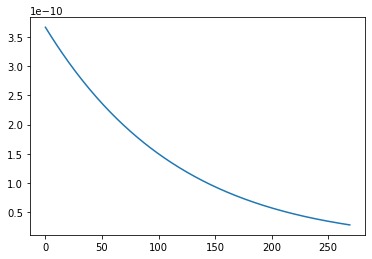

In [2]:
Isotope=pd.DataFrame({'ISO':["Ge76","Xe136","Te130"],
                     'EQ':[2.039,2.458,2.528],
                      'FWHM':[0.12e-2,2.7e-2,0.31e-2],
                     'T2vbb':[1.9,2.2,0.82],
                    'Color':['r','b','g']})       ##T2vbb is unit of 10^21 y
print(Isotope)

range_l=0
range_h=1.2
pointN=12000
E=np.linspace(range_l,range_h,pointN)
ISO_N=3

FE2v=np.zeros((pointN,ISO_N))
FE2vconv=np.zeros((pointN,ISO_N))
FE0v=np.zeros((pointN,ISO_N))
FE0vconv=np.zeros((pointN,ISO_N))
Sum2v=np.zeros((ISO_N,))
Sum0v=np.zeros((ISO_N,))
frac=np.zeros((10,))

for i in range(ISO_N):
    EQ=Isotope.loc[i,'EQ']
    FWHM=EQ*Isotope.loc[i,'FWHM']
    print(EQ,FWHM)
    FE2v[:,i]=double_betaF(EQ,pointN_=pointN)
    FE2vconv[:,i]=convFWHM(FE2v[:,i],FWHM)
    FE0vconv[:,i]=nless_double_betaF(EQ,FWHM,pointN_=pointN)

Sum2v=np.sum(FE2vconv,axis=0)
Sum0v=np.sum(FE0vconv,axis=0)
print(Sum2v,Sum0v)


start,end=convert(range_l,range_h,pointN,0.027)    
frac[0]=np.sum(FE2vconv[start:end:,1])
print(frac[0],start,end)
plt.plot(FE2vconv[start:end:,1])

#fig, ax = plt.subplots(1,1,figsize=(8,6),dpi=500)
# ResPulse[0:65]=fit_sig_tanhg[35:100]/fit_sig_tanhg[35:100].max()

# ax[0].set(xlabel='time(us)')
# ax[1].plot(np.linspace(0,7.99,800),ResPulse[0:800])
# ax[1].set(xlabel='time(us)')
# fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/ht.png")
#np.save("E:/CDEX/ovbb/WaveSimulation/response/ResPulse.npy",ResPulse)

0.0
0.0 1.0
nan
0.02


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

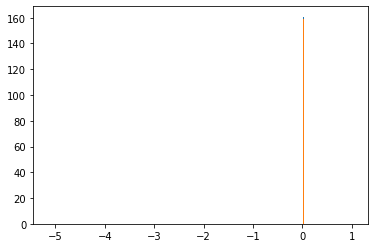

In [3]:
B_counts=0.01
S=0.01
P=0.50
Nbin=1000

ln=np.log((S+B_counts)/B_counts)
n_sample=100000
Data_Nb=stats.poisson.rvs(mu=B_counts,size=n_sample)
Data_Nsb=stats.poisson.rvs(mu=B_counts+S,size=n_sample) 
Q_Nb=-2*(Data_Nb*ln-S)
Q_Nsb=-2*(Data_Nsb*ln-S)
Min=np.min([Q_Nb.min(),Q_Nsb.min()])
Max=np.max([Q_Nb.max(),Q_Nsb.max()])
R=(Min-1,Max+1)
H_Nb,Edge=np.histogram(Q_Nb,bins=Nbin,range=R,density=True)
H_Nsb,Edge=np.histogram(Q_Nsb,bins=Nbin,range=R,density=True)
Nobs_50=np.max([0,stats.poisson.ppf(mu=B_counts,q=1-P)])  #observe s more than Nobs (poisson dist) with probability no less than 1-P
print(Nobs_50)
Qobs_50=-2*(Nobs_50*ln-S)
Nb_sum_mask=Edge[0:len(Edge)-1]<Qobs_50
Nsb_sum_mask=Edge[0:len(Edge)-1]>Qobs_50
Q_Nb_sum=H_Nb[Nb_sum_mask].sum()*(Edge[1]-Edge[0])
Q_Nsb_sum=H_Nsb[Nsb_sum_mask].sum()*(Edge[1]-Edge[0])
CLs=Q_Nsb_sum/(1-Q_Nb_sum)
print(Q_Nsb_sum,Q_Nb_sum)
print(CLs)
print(Qobs_50)
#print(Q_Nb,Q_Nsb)
plt.hist(Q_Nb,bins=Nbin,range=R,density=True)
plt.hist(Q_Nsb,bins=Nbin,range=R,density=True)

In [4]:
Isotope=pd.DataFrame({'ISO':["Ge76","Xe136","Te130"],
                      'M(A)':[76e-6,136e-6,130e-6],             #t/mol
                     'EQ':[2.039,2.458,2.528],
                      'FWHM':[0.12e-2,2.7e-2,0.31e-2],
                     'T2vbb':[1.9e21,2.2e21,0.82e21],
                    'Color':['r','b','g'],
                     'G0v':[2.363e-15,14.58e-15,14.22e-15],
                     'M0v':[6.13,4.32,4.98],
                     'Abd':[0.88,1,1]})       ##T2vbb is unit of 10^21 y

Exposure=3000
FWHM=[1e-2,3e-2,7.07e-2]
PointN=100
x_FWHM=np.linspace(0.12e-2,7.1e-2,PointN)
x_Exp=np.logspace(1,1e6,PointN)
Xembb_FWHM=np.zeros((PointN,))
Xembb_Exp=np.zeros((PointN,))
Mbb=np.zeros((3,))
Bkg=np.zeros((3,))
SB=np.zeros((3,))
T0vbb=np.zeros((3,))
IHmbb=14e-9
Exp=np.zeros((3,))

Isochose=2                  #1 for Xe136,2 for Te130
for i in range(0,3):
    MA   =Isotope.loc[Isochose,"M(A)"]
    EQ   =Isotope.loc[Isochose,"EQ"]
    T2vbb=Isotope.loc[Isochose,"T2vbb"]
    G0v  =Isotope.loc[Isochose,"G0v"]
    M0v  =Isotope.loc[Isochose,"M0v"]
    Abd  =Isotope.loc[Isochose,"Abd"]
    Mbb[i],Bkg[i],SB[i],T0vbb[i]=mbb(MA,EQ,T2vbb,G0v,M0v,FWHM[i],Exposure,Abd)
    SB[i],Exp[i]=sb(T2vbb,IHmbb,EQ,FWHM[i],G0v,M0v,MA)
    #print(FWHM[i])
    #Xembb_FWHM[i]=mbb(MA,EQ,T2vbb,G0v,M0v,x_FWHM[i],Exposure,Abd)
    #Xembb_Exp[i] =mbb(MA,EQ,T2vbb,G0v,M0v,FWHM[2],x_Exp[i],Abd)
#print(Mbb,Bkg,T0vbb,SB)
print(Exp)

4.2050880626223096e-11 5161.920483481064 107.6 166.19048184215308 3.7776998333881954e+27
3.065509197651662e-08 7.080823708478829 107.6 166.19048184215308 3.7776998333881954e+27
5.25159925410538e-06 0.04133280007670638 107.6 166.19048184215308 3.7776998333881954e+27
[166.19048184 166.19048184 166.19048184]


D:\Anaconda\lib\site-packages\numpy\core\function_base.py:279: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


In [5]:
a={"TPC":2.7,"Scin":4.5}
Isotope=pd.DataFrame({'ISO':["Ge76","Xe136","Te130"],
                      'M(A)':[76e-6,136e-6,130e-6],             #t/mol
                     'EQ':[2.039,2.458,2.528],
                      'FWHM':[0.12e-2,a,0.31e-2],
                     'T2vbb':[1.9e21,2.2e21,0.82e21],
                    'Color':['r','b','g'],
                     'G0v':[2.363e-15,14.58e-15,14.22e-15],
                     'M0v':[6.13,4.32,4.98],
                     'Abd':[0.88,1,1]})       ##T2vbb is unit of 10^21 y

In [6]:
print(Isotope.loc[1,"FWHM"])

{'TPC': 2.7, 'Scin': 4.5}
